[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/simple_detector_v2.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

## Предсказание

In [1]:
import json
import os
#import numpy as np 
#import pandas as pd 
import random
#import time

#import cv2
import torch
#import torch.utils.data
#from torch.utils.data import Dataset, DataLoader
import torchvision
#import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection import FasterRCNN

from PIL import Image
#import matplotlib.pyplot as plt
#import matplotlib.patches as patches

#from pycocotools.coco import COCO
import fiftyone as fo

In [2]:
img_path = 'data'

def load_model_detection(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps')
num_classes = 2
model = load_model_detection(num_classes)
model.to(device)
checkpoint = torch.load('checkpoints/model_detector_resnet50_0.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [5]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

def get_prediction(img_path, img_name, threshold):
    model.eval()
    img = Image.open(os.path.join(img_path, img_name))
    transforms=get_transform()
    img = transforms(img).to(device)
    prediction = model([img])
    pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(prediction[0]['boxes'].detach().cpu().numpy())]
    pred_labels = list(prediction[0].get('labels').cpu().numpy())
    pred_scores = list(prediction[0].get('scores').detach().cpu().numpy())
    pred_tr = [pred_scores.index(x) for x in pred_scores if x > threshold][-1]
    pred_labels = pred_labels[:pred_tr+1]
    pred_boxes = pred_boxes[:pred_tr+1]
    pred_scores = pred_scores[:pred_tr+1]
    
    #boxes = []
    #for i in range(num_objs):
    #    min = coco_annotation[i]['bbox'][0]
    #    ymin = coco_annotation[i]['bbox'][1]
    #    xmax = xmin + coco_annotation[i]['bbox'][2]
    #    ymax = ymin + coco_annotation[i]['bbox'][3]
    #    boxes.append([xmin, ymin, xmax, ymax])
    
    return pred_boxes, pred_labels, pred_scores

img_name = 'rtsd-frames/autosave16_10_2012_08_58_25_5.jpg'
threshold = 0.1
prediction = get_prediction(img_path, img_name, threshold)
prediction

([[1144.6566, 5.4704213, 1279.1117, 153.44415],
  [1148.1124, 17.563765, 1215.5217, 113.55655]],
 [1, 1],
 [0.8624712, 0.14893065])

In [22]:
def get_random_val_image_name():
    dataset_path = img_path
    with open(os.path.join(dataset_path, 'val_anno.json'), 'r') as read_file:
        val_anno = json.load(read_file)
    read_file.close()
    img_name = val_anno.get('images')[random.randint(0, len(val_anno.get('images')))].get('file_name')
    return img_name

def get_predict_anno(images_path, img_name, threshold):

    if img_name == None:
        img_name = get_random_val_image_name()


    pred_boxes, pred_labels, pred_scores = get_prediction(images_path, img_name, threshold)
    
    anno = {}

    images = []
    image_item = {}
    image_item['id'] = 0
    img = Image.open(os.path.join(images_path, img_name))
    transforms=get_transform()
    img = transforms(img).to(device)
    image_item['width'] = img.shape[2]
    image_item['height'] = img.shape[1]
    image_item['file_name'] = img_name
    images.append(image_item)
    anno['images'] = images

    annotations = []
    for i in range(len(pred_boxes)):
        anno_item = {}
        anno_item['id'] = i
        anno_item['image_id'] = 0
        anno_item['category_id'] = int(pred_labels[i])
        anno_item['area'] = (float(pred_boxes[i][2]) - float(pred_boxes[i][0]))*(float(pred_boxes[i][3]) - float(pred_boxes[i][1]))
        anno_item['bbox'] = [float(pred_boxes[i][0]), float(pred_boxes[i][1]), float(pred_boxes[i][2]) - float(pred_boxes[i][0]), float(pred_boxes[i][3]) - float(pred_boxes[i][1])]
        anno_item['iscrowd'] = 0
        annotations.append(anno_item)
    anno['annotations'] = annotations
    
    anno['categories'] = [{'id': 1, 'name': 'sign'}]

    with open(os.path.join(img_path, 'predicted_anno.json'), 'w') as f:
        json.dump(anno, f)#ensure_ascii=False, indent=4)
    f.close()



    # загрузка изображения в fiftyone
    data_path = images_path      # можно не указывать, если в JSON путь совпадает

    # The path yo the COCO labels JSON file
    labels_file = "train_anno_bin_class.json"
    labels_path = os.path.join(img_path, 'predicted_anno.json')


    # Import the dataset
    dataset = fo.Dataset.from_dir(
        dataset_type=fo.types.COCODetectionDataset,
        data_path=data_path,
        labels_path=labels_path
    )
    # Визуализация набора данных
    session = fo.launch_app(dataset)

    return anno


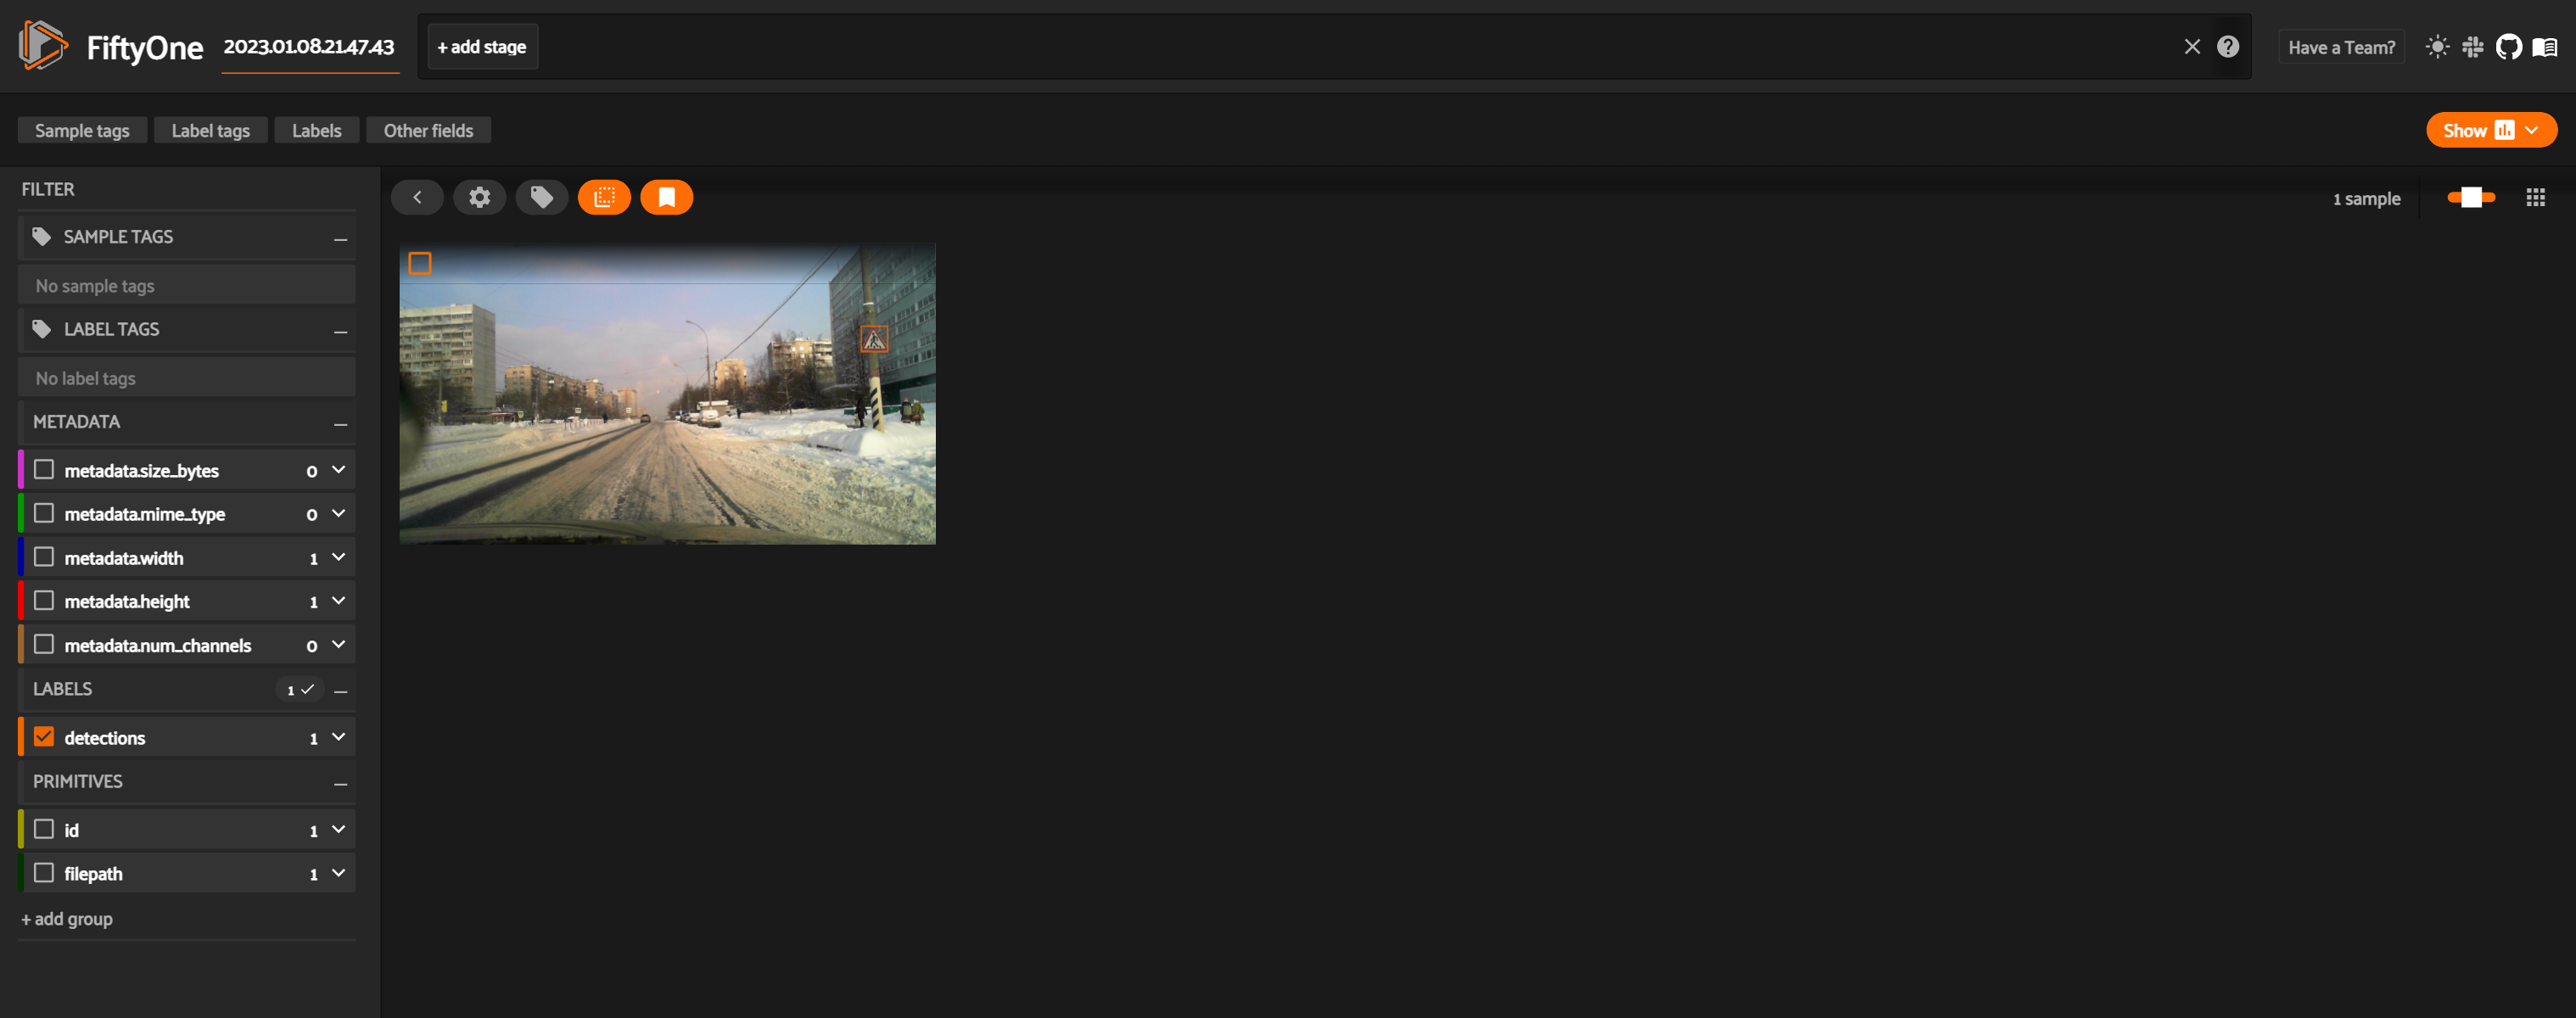

In [29]:
threshold = 0.7
#img_name = 'rtsd-frames/autosave13_04_2013_09_48_32_2.jpg'
prediction_anno = get_predict_anno(img_path, None, threshold)


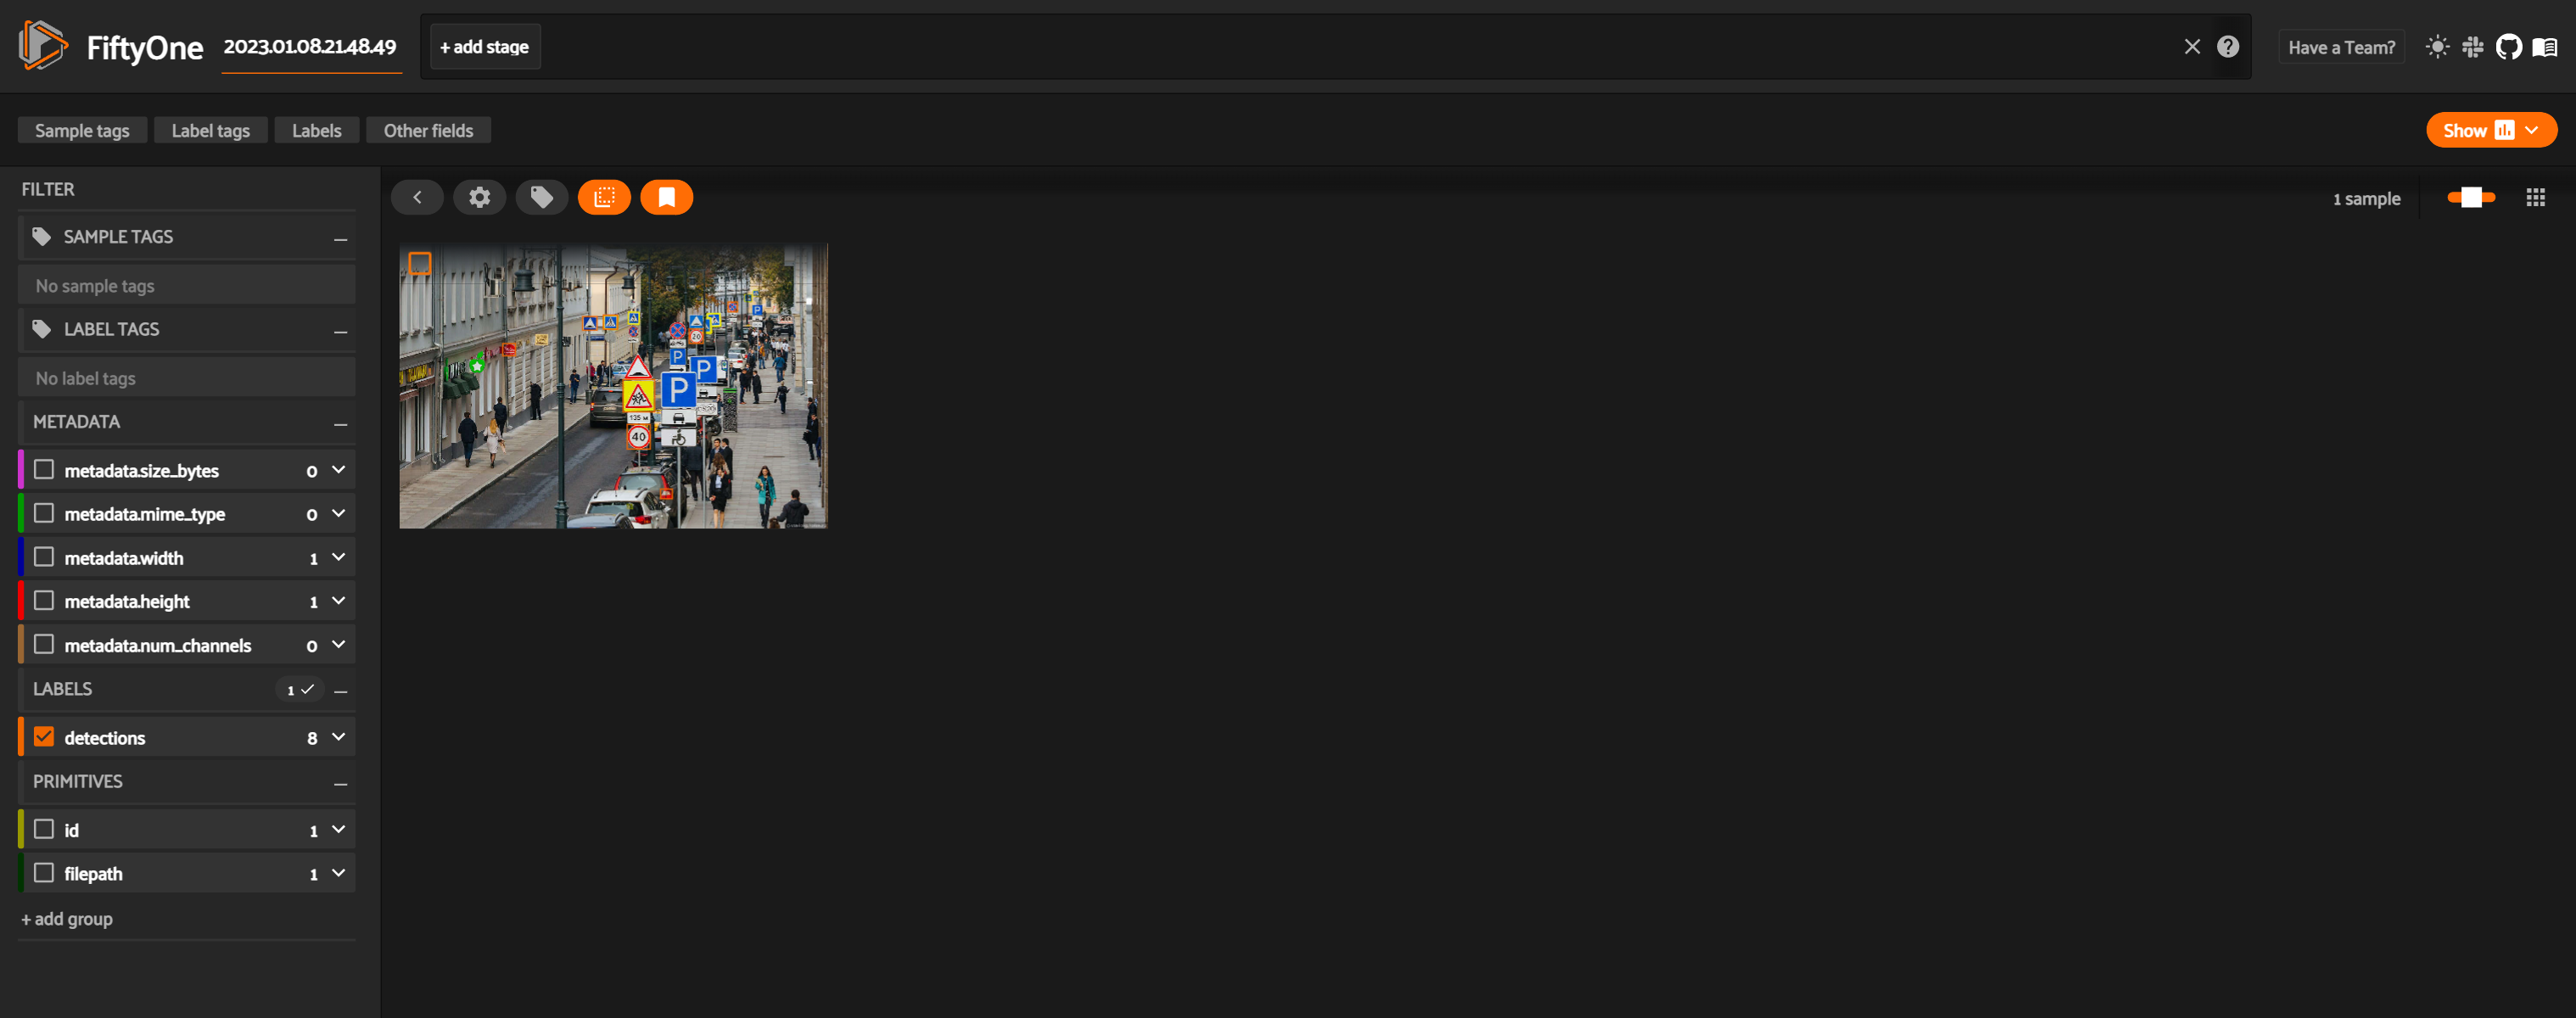

In [31]:
img_name = 'image_for_predict/image1.jpg'
threshold = 0.7
prediction_anno = get_predict_anno(img_path, img_name, threshold)


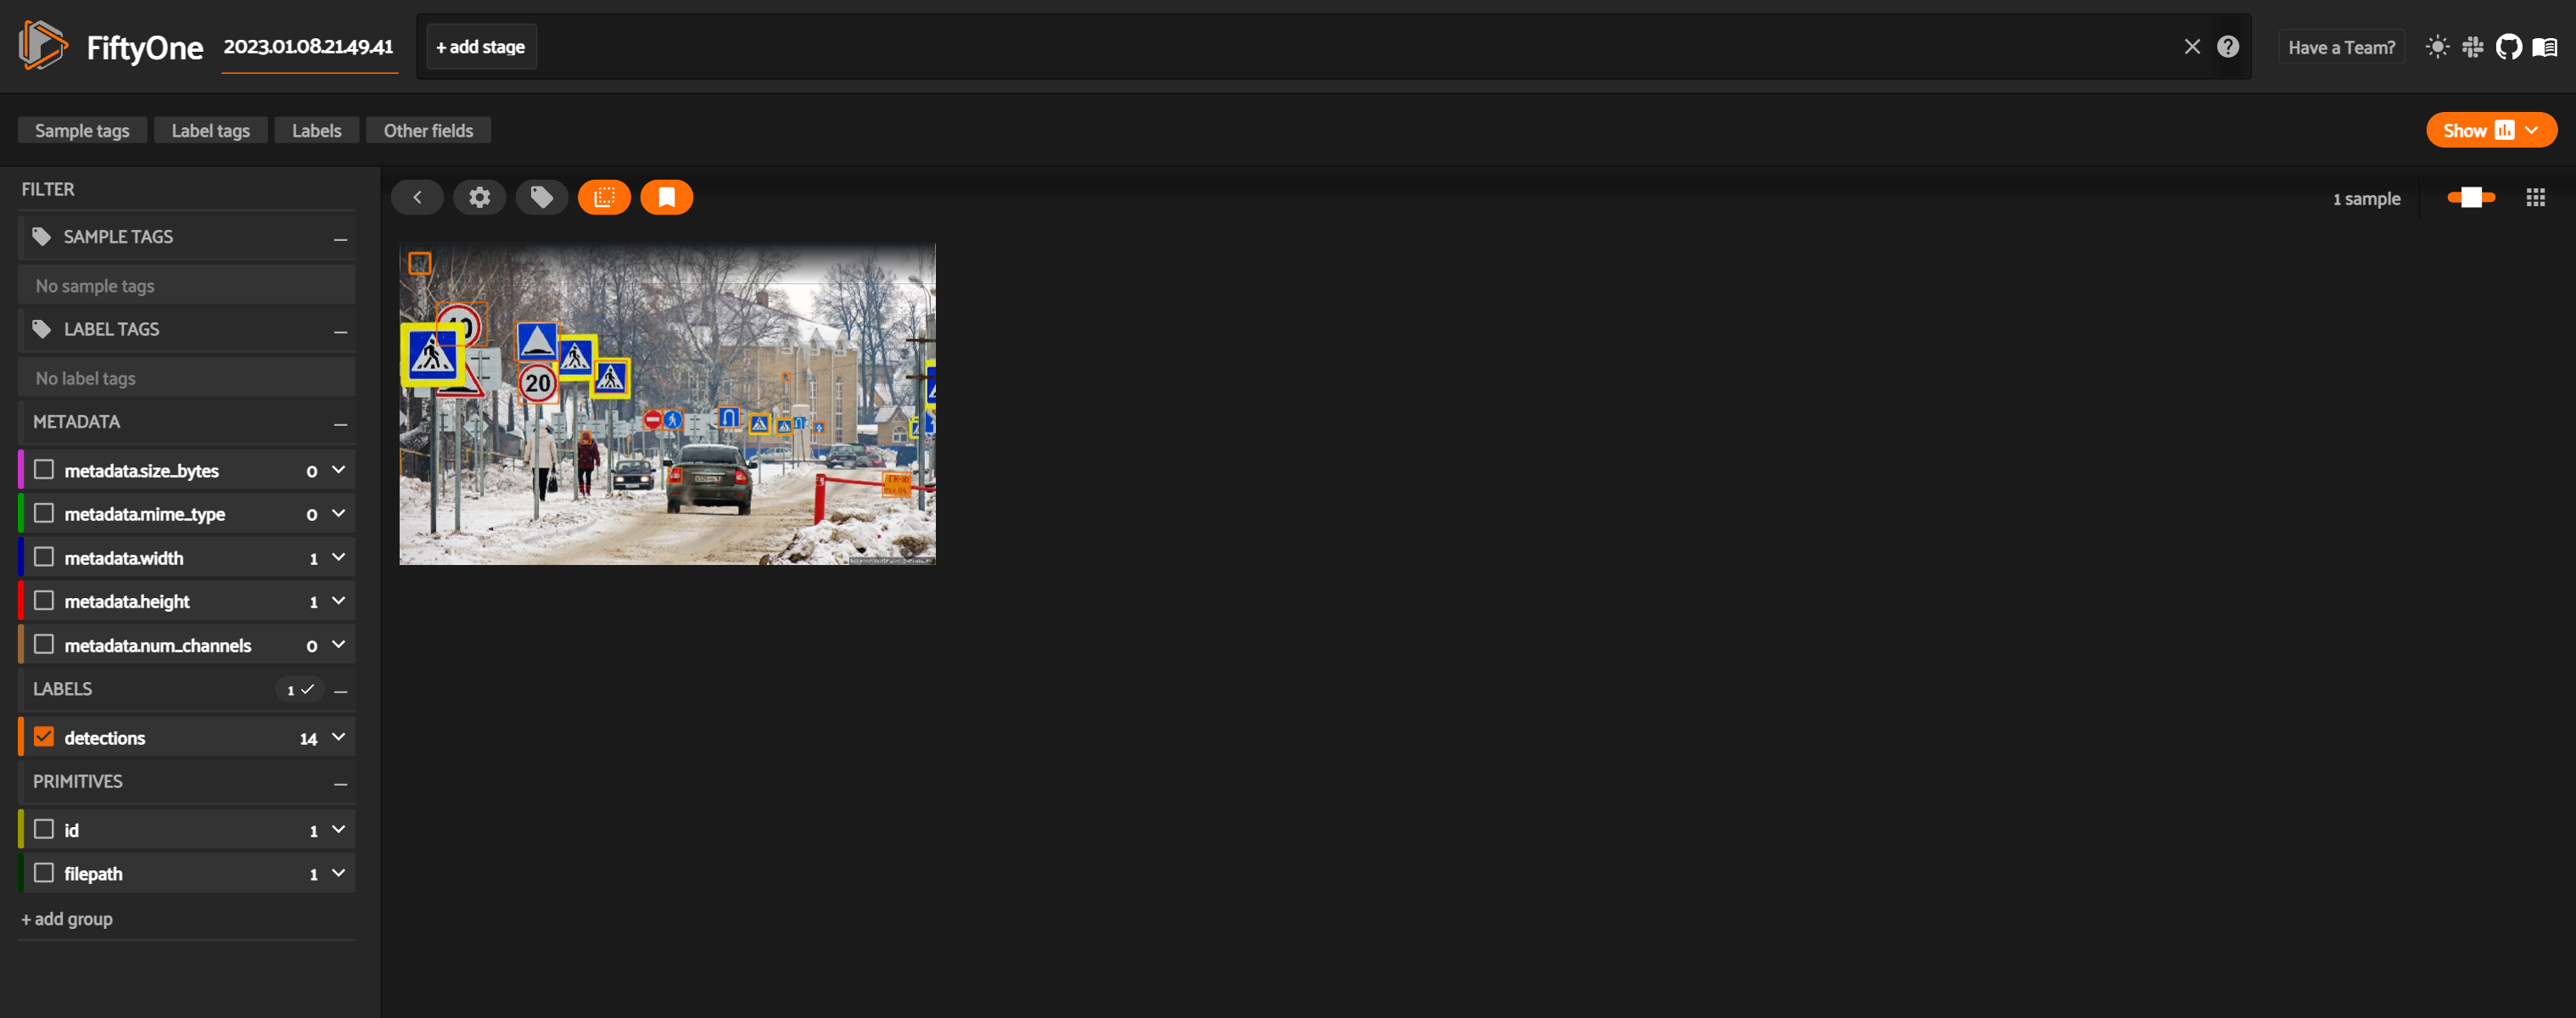

In [33]:
img_name = 'image_for_predict/image2.jpg'
threshold = 0.7
prediction_anno = get_predict_anno(img_path, img_name, threshold)


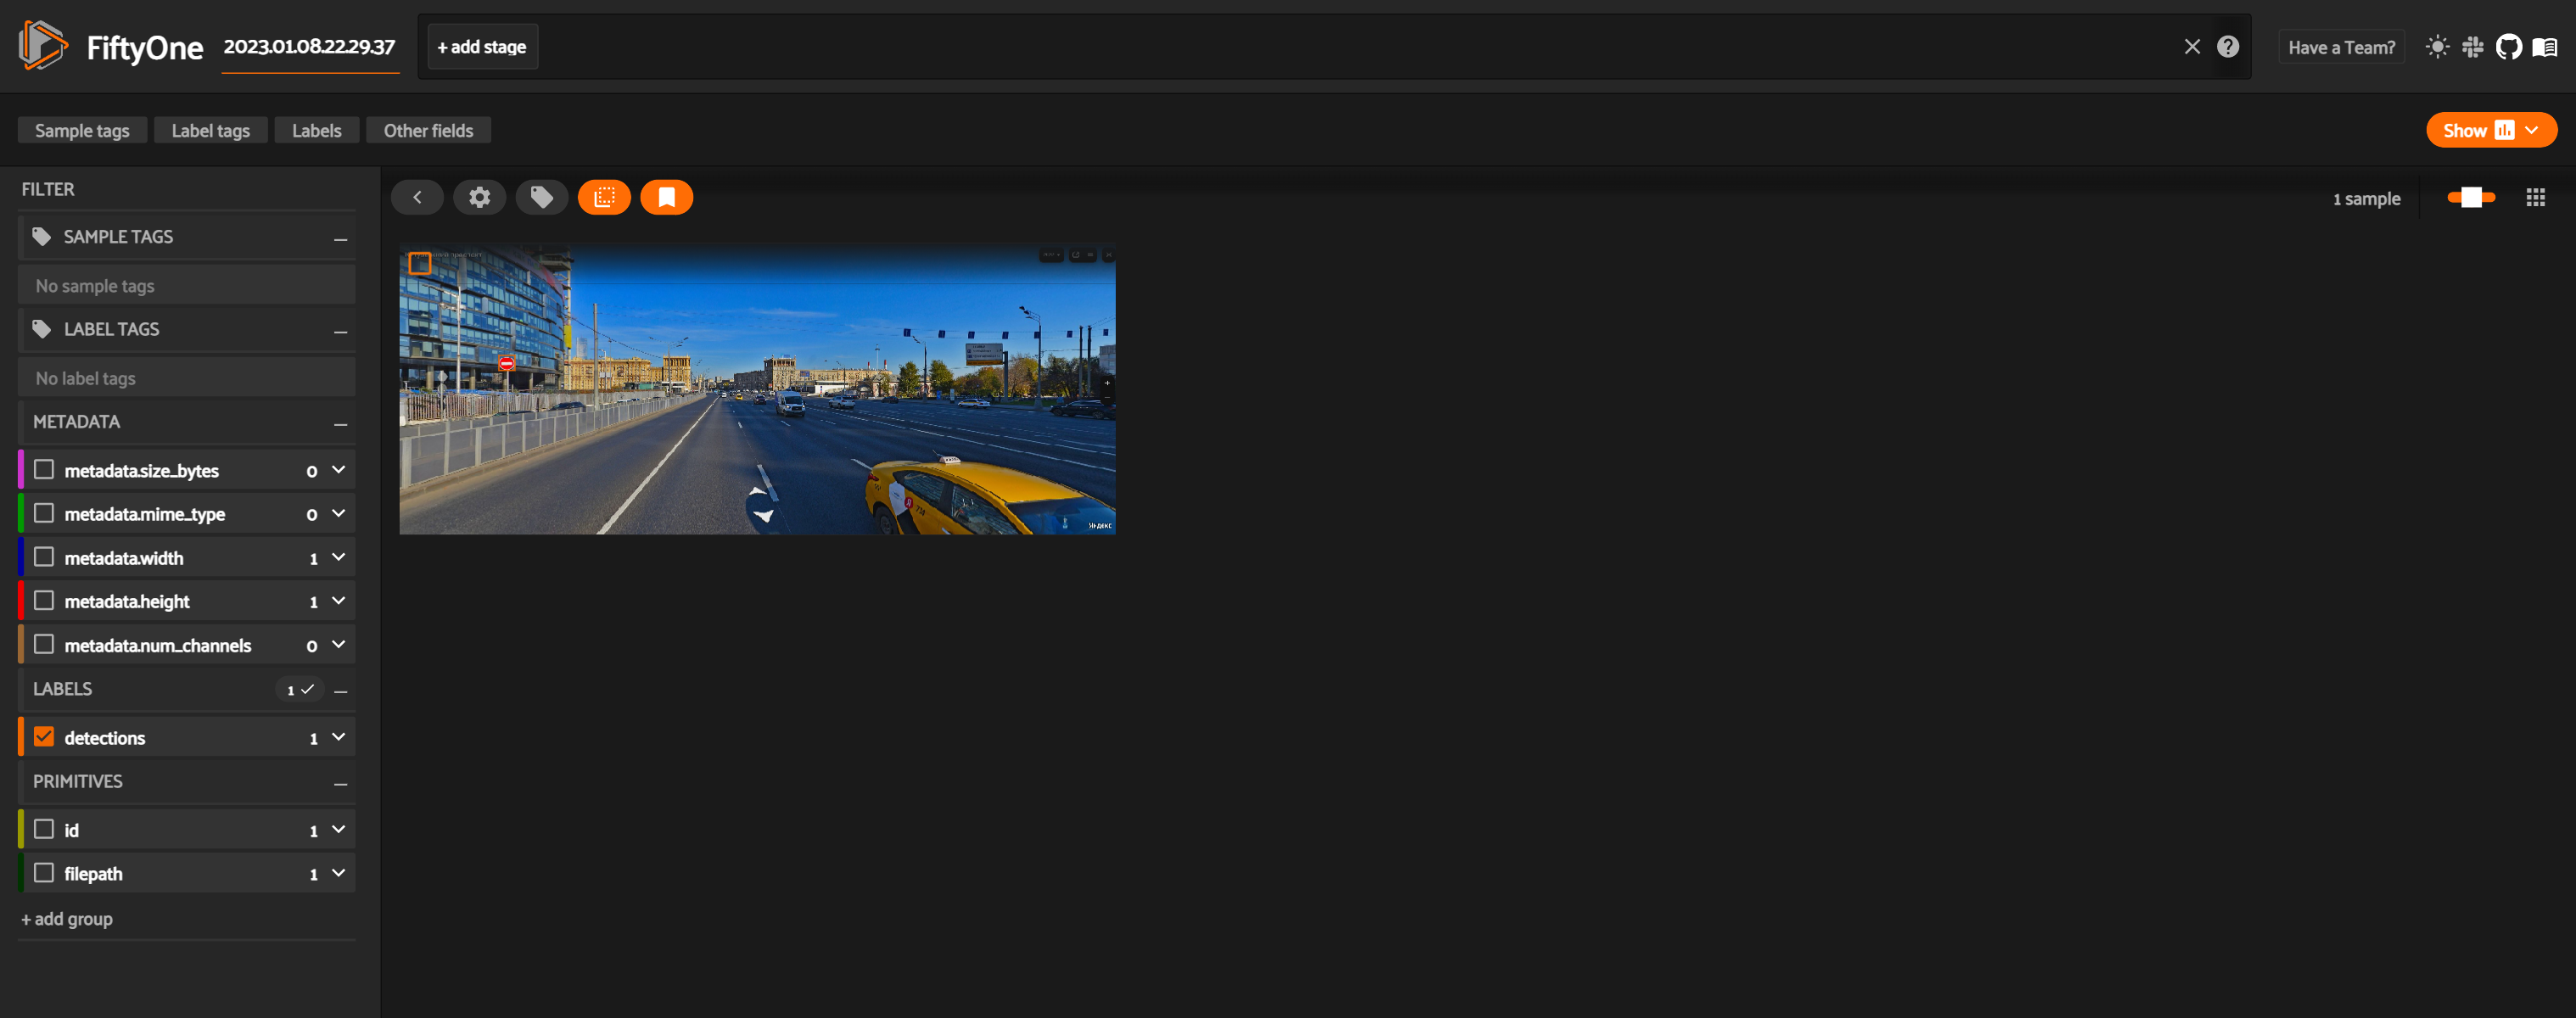

In [35]:
img_name = 'image_for_predict/screen1.jpg'
threshold = 0.7
prediction_anno = get_predict_anno(img_path, img_name, threshold)

In [36]:
img_name = 'image_for_predict/screen2.jpg'
threshold = 0.7
prediction_anno = get_predict_anno(img_path, img_name, threshold)


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds

Could not connect session, trying again in 10 seconds



Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 s